# Load data

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import math
from itertools import compress

C:\Users\Kenny\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_tag = pd.read_csv('train_tag.txt', sep=",", header=None)
train_tag.columns = ["video", "tag"]

train_tag['tag'] = to_categorical(train_tag['tag']).tolist()

In [3]:
label_length = len(train_tag['tag'][0])
label_length

15

In [4]:
train_tag.head()

,video,tag
0,873879927.mp4,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,872438072.mp4,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,796902701_219_229.mp4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
3,829923135_39_49.mp4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
4,859022208.mp4,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [5]:
def load_mp4(file,size = (60,60,3),frames = 20):
    v = []
    cap = cv2.VideoCapture(file)
    while(cap.isOpened()):
        ret, frame = cap.read()
        if frame is None:
            break
        frame = cv2.resize(frame, dsize=size[::-1][1:3], interpolation=cv2.INTER_CUBIC)
        v.append(frame)
    cap.release()
    v = np.array(v)
    v = v[::math.ceil(v.shape[0]/20)] #extract 20 frames
    more = np.reshape(v[-1],(1,v.shape[1],v.shape[2],v.shape[3]))
    
    while v.shape[0] != frames:
        v = np.vstack((v,more))

    return v


In [6]:
path = 'train_video/'
x =[] 
y =[]

img_size = (60,60,3)
frames = 20
size = 537

for filename in os.listdir(path):
    if filename.endswith(".mp4"):
        v = load_mp4(path + filename,img_size,frames)
        x.append(v)
        tag = train_tag['tag'][train_tag['video']==filename].values[0]
        y.append(tag)
    #print(len(x))
    if len(x) == size:
        break

In [7]:
x=np.array(x)
x.shape

(537, 20, 60, 60, 3)

In [8]:
y = np.array(y)
y.shape

(537, 15)

In [9]:
msk = np.random.rand(len(x)) < 0.8
x_train=x[msk]
y_train=y[msk]
x_test=x[~msk]
y_test=y[~msk]
print('x_train shape: ',x_train.shape)
print('y_train shape: ',y_train.shape)
print('x_test shape: ',x_test.shape)
print('y_test shape: ',y_test.shape)

x_train shape:  (426, 20, 60, 60, 3)
y_train shape:  (426, 15)
x_test shape:  (111, 20, 60, 60, 3)
y_test shape:  (111, 15)


In [10]:
def show_data(index,x,y):
    print('label: ', y[index])
    plt.figure(figsize=(20,10))
    columns = 5
    images=x_train[index]
    print('shape: ',images.shape)
    for i, image in enumerate(images):
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.imshow(image)

label:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
shape:  (20, 60, 60, 3)


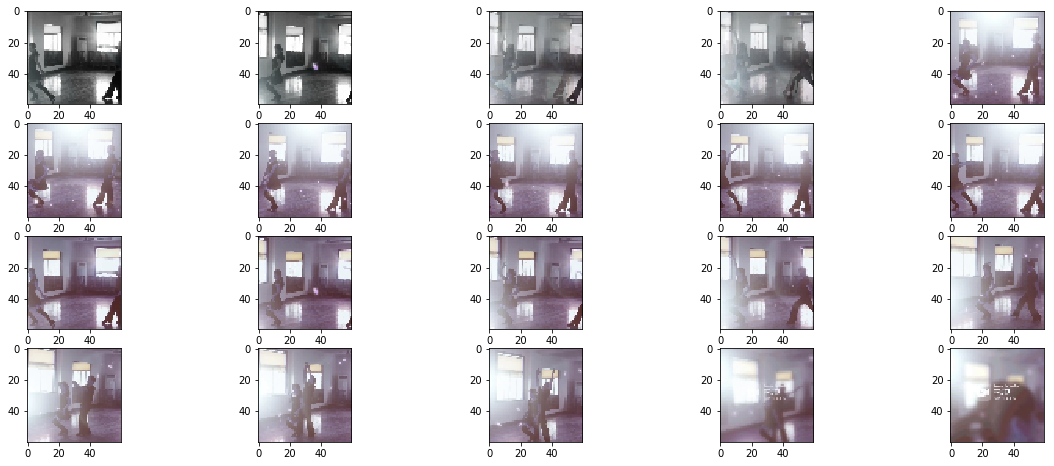

In [11]:
show_data(39,x_train,y_train)

# Model

In [12]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution3D, MaxPooling3D
from keras.layers import LSTM,GlobalMaxPooling3D,BatchNormalization

In [13]:
kernel_size = (3,3,3)  #temporal,spatio,spatio
filter_size = 64
pool_size = (2,2,2)
input_shape=(frames,)+img_size
batch_size=10

In [14]:
model = Sequential()

model.add(Convolution3D(
    nb_filter=filter_size,
    kernel_dim1 = kernel_size[0],
    kernel_dim2 = kernel_size[1],
    kernel_dim3 = kernel_size[2],
    input_shape = input_shape,
    dim_ordering='tf'))
model.add(Convolution3D(
    nb_filter=filter_size,
    kernel_dim1 = kernel_size[0],
    kernel_dim2 = kernel_size[1],
    kernel_dim3 = kernel_size[2],
    dim_ordering='tf'))

model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Convolution3D(
    nb_filter=filter_size * 2,
    kernel_dim1 = kernel_size[0],
    kernel_dim2 = kernel_size[1],
    kernel_dim3 = kernel_size[2],
    dim_ordering='tf'))
model.add(Convolution3D(
    nb_filter=filter_size * 2,
    kernel_dim1 = kernel_size[0],
    kernel_dim2 = kernel_size[1],
    kernel_dim3 = kernel_size[2],
    dim_ordering='tf'))

model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(GlobalMaxPooling3D())
#model.add(Dense(128,activation="relu"))
model.add(Dense(label_length,activation="softmax"))

C:\Users\Kenny\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(input_shape=(20, 60, 6..., kernel_size=(3, 3, 3), filters=64, data_format="channels_last")`
  if __name__ == '__main__':
C:\Users\Kenny\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(kernel_size=(3, 3, 3), filters=64, data_format="channels_last")`
  from ipykernel import kernelapp as app
C:\Users\Kenny\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(kernel_size=(3, 3, 3), filters=128, data_format="channels_last")`
C:\Users\Kenny\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(kernel_size=(3, 3, 3), filters=128, data_format="channels_last")`


In [15]:
opt='adam'
loss='categorical_crossentropy'
metrics=['accuracy']
model.compile(optimizer=opt, loss=loss, metrics=metrics)

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 18, 58, 58, 64)    5248      
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 16, 56, 56, 64)    110656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 56, 56, 64)    256       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 28, 28, 64)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 6, 26, 26, 128)    221312    
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 4, 24, 24, 128)    442496    
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 24, 24, 128)    512       
__________

In [17]:
history = model.fit(x_train, y_train,
                  batch_size=batch_size, epochs=30,
                  validation_data=(x_test, y_test),verbose = 1)

Train on 438 samples, validate on 99 samples
Epoch 1/30
438/438 [==============================] - 23s 53ms/step - loss: 3.0770 - acc: 0.1507 - val_loss: 2.4114 - val_acc: 0.2222
Epoch 2/30
438/438 [==============================] - 17s 39ms/step - loss: 2.3238 - acc: 0.2123 - val_loss: 3.6670 - val_acc: 0.1616
Epoch 3/30
438/438 [==============================] - 17s 40ms/step - loss: 2.2996 - acc: 0.2694 - val_loss: 2.4134 - val_acc: 0.2323
Epoch 4/30
438/438 [==============================] - 18s 40ms/step - loss: 2.1666 - acc: 0.3219 - val_loss: 2.1532 - val_acc: 0.2929
Epoch 5/30
438/438 [==============================] - 18s 41ms/step - loss: 2.0699 - acc: 0.3607 - val_loss: 3.0671 - val_acc: 0.1717
Epoch 6/30
438/438 [==============================] - 18s 41ms/step - loss: 2.0392 - acc: 0.3607 - val_loss: 3.3506 - val_acc: 0.2424
Epoch 7/30
438/438 [==============================] - 19s 43ms/step - loss: 1.9126 - acc: 0.3721 - val_loss: 2.5301 - val_acc: 0.1919
Epoch 8/30
438/43

['seaborn-whitegrid', 'seaborn-dark', 'classic', 'seaborn-darkgrid', 'Solarize_Light2', '_classic_test', 'seaborn', 'bmh', 'seaborn-notebook', 'seaborn-deep', 'fivethirtyeight', 'seaborn-paper', 'seaborn-poster', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn-dark-palette', 'seaborn-white', 'seaborn-bright', 'grayscale', 'seaborn-ticks', 'dark_background', 'fast', 'seaborn-talk', 'seaborn-pastel', 'tableau-colorblind10']


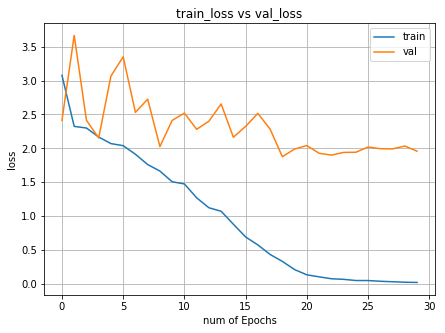

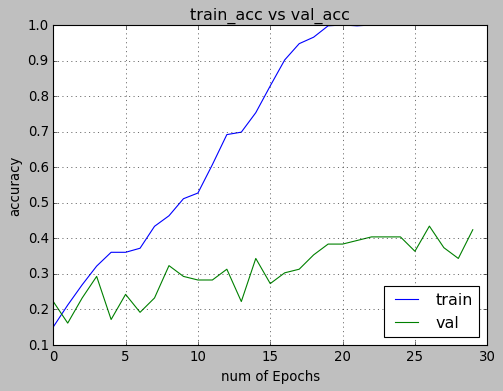

In [18]:
train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['acc']
val_acc=history.history['val_acc']
xc=range(30)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
print (plt.style.available) # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

# Prediction

In [19]:
path = 'test_video/'
out_x =[] 
filenames = []
img_size = (60,60,3)
frames = 20

for filename in os.listdir(path):
    if filename.endswith(".mp4"):
        v = load_mp4(path + filename,img_size,frames)
        filenames.append(filename)
        out_x.append(v)

In [20]:
out_x = np.array(out_x)
out_x.shape

(505, 20, 60, 60, 3)

In [21]:
prediction = model.predict(out_x)

In [22]:
prediction=np.argmax(prediction,axis=1)
print(filenames[0:5])
print(prediction[0:5])

['30018754.mp4', '303746162.mp4', '303771055.mp4', '303783414.mp4', '303785363.mp4']
[ 4 11  9  9  6]


In [23]:
result_df=pd.DataFrame()
result_df['file_name'] = filenames
result_df['label'] = prediction
result_df.to_csv('Q6_output.csv',index=False)
result_df.head(10)

,file_name,label
0,30018754.mp4,4
1,303746162.mp4,11
2,303771055.mp4,9
3,303783414.mp4,9
4,303785363.mp4,6
5,303835132.mp4,0
6,303922809.mp4,9
7,30393422.mp4,12
8,303942687.mp4,0
9,303996365.mp4,11
